In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from encoder.digit_encoder import small_int_vector_asimage
from sparse_causal_model_learner_rl.trainable.combined import FCCombinedModel
from sparse_causal_model_learner_rl.loss.losses import manual_switch_gradient
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, LearnableSwitchSimple
import seaborn as sns
from functools import partial
from tqdm.auto import tqdm
import pandas as pd
from causal_util.helpers import lstdct2dctlst
from math import ceil
import gin
gin.enter_interactive_mode()

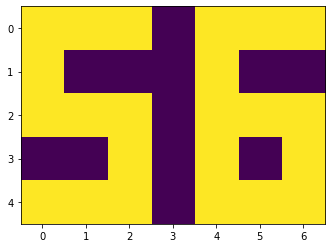

In [2]:
plt.imshow(small_int_vector_asimage([5, 6]))

In [3]:
# device = torch.device('cuda')
device = torch.device('cpu')

In [816]:
features = [(x, y) for x in torch.arange(10) for y in torch.arange(10)] * 5
actions = [(np.random.choice([-1, 1, 0]), np.random.choice([-1, 1, 0])) for _ in range(len(features))]
actions = torch.from_numpy(np.array(actions)).to(torch.float32).to(device)
print(len(features))
obs = torch.from_numpy(np.array([small_int_vector_asimage([int(t1), int(t2)]) for t1, t2 in features], dtype=np.float32)).to(device).detach()

500


In [817]:
idxes = list(range(len(obs)))

In [820]:
# idxes_perm = idxes[1:] + idxes[0:1]
# idxes_perm, idxes
# features_perm = [(y, x) for x, y in features]
def clamp(v, m, M):
    if v < m:
        v = m
    elif v > M:
        v = M
    return v
features_perm = [(clamp(f1.item() + a1.item(), 0, 9), clamp(f2.item() + a2.item(), 0, 9)) for ((f1, f2), (a1, a2)) in zip(features, actions)]

In [821]:
features[:5], actions[:5], features_perm[:5]

([(tensor(0), tensor(0)),
  (tensor(0), tensor(1)),
  (tensor(0), tensor(2)),
  (tensor(0), tensor(3)),
  (tensor(0), tensor(4))],
 tensor([[-1., -1.],
         [ 1., -1.],
         [ 1.,  1.],
         [ 0., -1.],
         [ 0.,  1.]]),
 [(0, 0), (1.0, 0.0), (1.0, 3.0), (0.0, 2.0), (0.0, 5.0)])

In [822]:
obs_next = torch.from_numpy(np.array([small_int_vector_asimage([int(t1), int(t2)]) for t1, t2 in features_perm], dtype=np.float32)).to(device).detach()

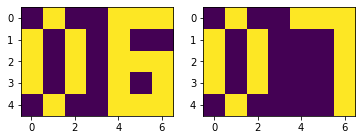

In [823]:
idx = 6
plt.subplot(1, 2, 1)
plt.imshow(obs[idx].detach().cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(obs_next[idx].detach().cpu().numpy())

In [824]:
obs_std = obs.std(0, keepdim=True)
obs_std = torch.where(obs_std < 1e-8, torch.ones_like(obs_std), obs_std)
obs_std

tensor([[[0.4004, 0.4004, 0.4004, 1.0000, 0.4004, 0.4004, 0.4004],
         [0.4904, 0.3003, 0.4587, 1.0000, 0.4904, 0.3003, 0.4587],
         [0.4004, 0.4004, 0.3003, 1.0000, 0.4004, 0.4004, 0.3003],
         [0.4904, 0.3003, 0.4004, 1.0000, 0.4904, 0.3003, 0.4004],
         [0.5005, 0.4904, 0.4004, 1.0000, 0.5005, 0.4904, 0.4004]]])

In [862]:
shape = obs.shape[1:]
size = np.prod(shape)
print(shape, size)
n_f = 3
n_a = 2
min_proba = 0.01

torch.Size([5, 7]) 35


In [915]:
class WithInputFC(nn.Module):
    def __init__(self, m, n_units):
        super(WithInputFC, self).__init__()
        self.m = m
        self.bn = nn.BatchNorm1d(n_units)
        self.fc1 = nn.Linear(n_units, n_units)
#         self.fc1.weight.data[:] = torch.eye(3)
#         self.fc1.bias.data[:] = 0
    def forward(self, x):
#         x = self.bn(x)
        x = self.fc1(x)# + x
        x = self.m(x)
        return x
    
class WithOutputFC(nn.Module):
    def __init__(self, m, n_units):
        super(WithOutputFC, self).__init__()
        self.m = m
        self.fc1 = nn.Linear(n_units, n_units)
#         self.fc1.weight.data[:] = 0
#         self.fc1.bias.data[:] = 0
#         self.fc1 = FCCombinedModel(input_shape=(n_units,),
#                                    output_shape=(n_units,),
#                                    hidden_sizes=[],
#                                    activation_cls=None,
#                                    input_reshape=True)
        self.bn = nn.BatchNorm1d(n_units)
    def forward(self, x):
        x = self.m(x)
#         x = self.bn(x)
        x = self.fc1(x)# + x
        return x
    
class WithLinTransform(nn.Module):
    def __init__(self, m, n_units):
        super(WithLinTransform, self).__init__()
        self.model = m
        self.n_features = n_f
        self.n_actions = n_a
        self.n_additional_features = 0
        self.fc1 = nn.Linear(n_units, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.fc1.weight.data[:] += torch.eye(n_units)
        self.fc1.bias.data[:] = 0.0
        self.bn = nn.BatchNorm1d(n_units)

#     def project(self):
#         M = self.fc1.weight
#         M.data = torch.clamp(M, -1, 1)
# #         M.data[M.data < -1] = -1.
# #         M.data[M.data > 1] = 1.
        
    def rotate(self, x):
        return self.fc1(x)
    
    def forward(self, x, detach_rotate=False, **kwargs):
        # shape: batch, features
#         self.project()
        
#         M = self.fc1.weight
#         A = (M - M.t()) / 2
#         I = torch.eye(self.n_features, device=M.device)
#         print(A, I - A)
#         S = (I + A) @ torch.pinverse(I - A)
#         Sinv = (I - A) @ torch.pinverse(I + A)
#         M = self.fc1.weight

#         if detach_rotate:
#             M = M.detach()
#         M = M + 
#         S = nn.Softmax(1)(M)
#
#         Sinv = torch.pinverse(M)#.detach()
        
#         x = (x @ M) + self.fc1.bias
        x = self.rotate(x)
        x = self.model(x, **kwargs)
#         x = (x - self.fc1.bias) @ Sinv#nn.Softmax(1)(self.fc1.weight)
#         x = self.bn(x)
        return x

class InputRotation(nn.Module):
    def __init__(self, n_units=n_f):
        super(InputRotation, self).__init__()
        self.fc1 = nn.Linear(n_units, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.fc1.weight.data[:] += torch.eye(n_units)
        self.fc1.bias.data[:] = 0.0
    def Wb(self):
        return self.fc1.weight, self.fc1.bias
        
    def forward(self, x):
        W, b = self.Wb()
        return (x @ W) + b
    
    def unrotate(self, x):
        W, b = self.Wb()
        return (x - b) @ torch.pinverse(W)
        
        
rot1 = InputRotation().to(device)
rot2 = InputRotation().to(device)

    
dec = FCCombinedModel(input_reshape=True,#WithOutputFC(
                      add_input_batchnorm=True,
                      input_shape=(size,),
                      output_shape=(n_f,),
                      hidden_sizes=[100, 25],
                      activation_cls=nn.LeakyReLU).to(device)#, n_f).cuda()
rec = FCCombinedModel(input_reshape=True, #WithInputFC(
                      input_shape=(n_f,),
                      output_shape=(size,),
                      add_input_batchnorm=True,
                      hidden_sizes=[100, 25],
                      activation_cls=nn.LeakyReLU).to(device)#, n_f).cuda()
model = WithInputSwitch(model_cls=partial(FCCombinedModel,
                                          output_shape=(1,),
                                          add_input_batchnorm=True,
                                          hidden_sizes=[100, 25],
                                          activation_cls=nn.LeakyReLU),
                        input_shape=(n_f + n_a,),
                        switch_cls=partial(LearnableSwitchSimple, initial_proba=min_proba,
                                           min_proba=min_proba),
                        give_mask=True,
                        n_models=n_f).to(device)#), n_f).to(device)


# model_ = model

[False, False, False]
[35, 100, 25, 1] 3
[False, False, False]
[3, 100, 25, 1] 35
[False, False, False]
[10, 100, 25, 1] 3


In [916]:
class MM(nn.Module):
    def __init__(self, model):
        super(MM, self).__init__()
        self.model = model
        self.n_features = n_f
        self.n_actions = n_a
        self.n_additional_features = 0
    def forward(self, *args, **kwargs):
        if 'all' in kwargs:
            del kwargs['all']
            if len(args) > 1:
                args = args[0:1]
        return self.model(*args, **kwargs)
model_ = MM(model)

In [917]:
(rec(dec(obs.flatten(start_dim=1))).view(obs.shape[0], *shape) - obs).flatten(start_dim=1).pow(2).sum(1).mean(0)

tensor(19.2622, grad_fn=<MeanBackward1>)

In [918]:
@gin.configurable
def manual_switch_gradient(loss_delta_noreduce, model, loss_scale=1.0,
                           eps=1e-5):
    """Fill in the gradient of switch probas manually

    Assuming that the batch size is enough to estimate mean loss with
     p on and off.
    """
    mask = model.model.last_mask
    input_dim = model.n_features + model.n_actions
    output_dim = model.n_features + model.n_additional_features

    delta = loss_delta_noreduce

    # if have two dimensions, assuming delta in the form of (batch, n_output_features)
    if len(delta.shape) == 2:
        delta_expanded = delta.view(delta.shape[0], 1, delta.shape[1]).expand(-1, input_dim, -1)
    elif len(delta.shape) == 1:  # assuming shape (batch, )
        delta_expanded = delta.view(delta.shape[0], 1, 1).expand(-1, input_dim, output_dim)
    mask_coeff = (mask - 0.5) * 2

    mask_pos = mask
    mask_neg = 1 - mask
    n_pos = (mask_coeff > 0).sum(dim=0) + eps
    n_neg = (mask_coeff < 0).sum(dim=0) + eps

    mask_pos = mask_pos / n_pos
    mask_neg = mask_neg / n_neg

    mask_atleast = ((n_pos >= 1) * (n_neg >= 1))
    mask_coeff = mask_atleast * (mask_pos - mask_neg)
    p_grad = (delta_expanded * mask_coeff).sum(dim=0)
    
#     val = 0.01
#     p_grad = torch.where(p_grad > 0.1, torch.ones_like(p_grad) * val,
#                          -torch.ones_like(p_grad) * val)

    p_grad = p_grad * loss_scale
    

    if model.model.switch.probas.grad is None:
        model.model.switch.probas.grad = p_grad.clone()
    else:
        model.model.switch.probas.grad += p_grad.clone()

#     model_.model.switch.probas.data[:] = 0
#     model_.model.switch.probas.data[0, 0] = 1.0
    return 0.0


In [919]:
#2 ** (-model_.model.last_mask.flatten(start_dim=1).sum(1))

In [920]:
def tensor_std(t, eps=1e-8):
    s = t.std(0, keepdim=True)
    s = torch.where(s < eps, torch.ones_like(s), s)
    return s

def rec_loss_std(obs, obs_rec, nomean=False):
    delta = (obs - obs_rec)
    delta = delta / obs_std
    loss = delta.flatten(start_dim=1).pow(2).sum(1)
    if not nomean:
        loss = loss.mean(0)
    return loss

def acc_one(obs, obs_rec):
    acc = (((obs > 0.5) == (obs_rec > 0.5)) * 1.0).flatten(start_dim=1).mean()
    return acc

def rec_loss():
    f_pred = dec(obs.flatten(start_dim=1))
    obs_rec = rec(f_pred).view(obs.shape[0], *shape)
    loss = rec_loss_std(obs, obs_rec)
    acc = acc_one(obs, obs_rec)
    return {'loss': loss, 'metrics': {'acc': acc.item()}}

def fit_loss(force_proba=None, fill_switch_grad=False, detach_features=False,
             msw_coeff=1.0):
    
    with torch.set_grad_enabled(not detach_features):
        f_curr = dec(obs.flatten(start_dim=1))
        f_next = dec(obs_next.flatten(start_dim=1))
        f_curr_post = rot1(f_curr)
        f_next_post = rot1(f_next)
        
#     detach_rotate = detach_features
    f_curr_witha = torch.cat([f_curr_post, actions], dim=1)
    f_pred = model(f_curr_witha, force_proba=force_proba)
    
#     with torch.set_grad_enabled(not detach_features):
    f_pred_torec = rot2(f_pred)
    
    obs_next_pred = rec(f_pred_torec).view(obs.shape[0], *shape)
    
    delta_f = (f_next_post - f_pred)
    std_f = tensor_std(f_curr_post)    
    delta_f = delta_f / std_f
    loss_fcons = delta_f.pow(2).sum(1)

    
    delta_f_post = (f_pred_torec - f_next)
    std_f_post = tensor_std(f_curr)
    delta_f_post = delta_f_post / std_f_post    
    loss_fcons_post = delta_f_post.pow(2).sum(1)
    
    
    loss = rec_loss_std(obs_next, obs_next_pred, nomean=True)
    acc = acc_one(obs_next, obs_next_pred)
    
    loss_total = loss + loss_fcons + loss_fcons_post
    
    if fill_switch_grad:
        manual_switch_gradient(loss_delta_noreduce=loss_total, model=model_,
                               loss_scale=msw_coeff)
    
    loss_total = loss_total.mean(0)# + loss_total.std(0)
    
    return {
        'loss': loss_total,
        'metrics': {
            'rec': loss.mean(0).item(),
            'fcons': loss_fcons.mean(0).item(),
            'fcons_post': loss_fcons_post.mean(0).item(),
            'acc': acc.item()
    }}

def sparsity_loss():
    t = list(model_.model.switch.parameters())[0]
    return {'loss': t.abs().sum(), 'metrics': {}}

def total_loss(coeffs=None):
    if coeffs is None:
        coeffs = {}
    
    metrics = {}
    
    losses = {'rec': rec_loss,
              'fit': partial(fit_loss, fill_switch_grad=True, msw_coeff=coeffs['fit']), # need this one, otherwise other features will likely decrease
                                                               # the loss, since the probas are 0.5 and features can be duplicated
              'fit_half': partial(fit_loss, force_proba=0.5, detach_features=True, fill_switch_grad=True,
                                  msw_coeff=coeffs['fit_half']),
              'fit_all': partial(fit_loss, force_proba=1.0, detach_features=True),
              'sparsity': sparsity_loss
              }
    
    total_loss = 0.0
    
    for key, fcn in losses.items():
        data = fcn()
        coef = coeffs.get(key, 1.0)
        total_loss += data['loss'] * coef
        for m_key, m_val in data['metrics'].items():
            metrics[f'{m_key}/{key}'] = m_val
        metrics[f'loss/{key}'] = data['loss'].item()
            
    return total_loss, metrics

In [921]:
crit_ratio = 1.5
sp_min = 1e-9
sp_max = 100
coeffs = {'rec': 10.0, 'fit': 20.0, 'fit_half': 0.001, 'fit_all': 1.0, 'sparsity': sp_min}

In [922]:
metrics_hist = []

In [923]:
rec_loss(), fit_loss(), fit_loss(force_proba=0.5), fit_loss(force_proba=1.0), sparsity_loss()

({'loss': tensor(118.4358, grad_fn=<MeanBackward1>),
  'metrics': {'acc': 0.4571428596973419}},
 {'loss': tensor(158.6290, grad_fn=<MeanBackward1>),
  'metrics': {'rec': 115.26002502441406,
   'fcons': 17.065576553344727,
   'fcons_post': 26.303367614746094,
   'acc': 0.4601143002510071}},
 {'loss': tensor(153.9302, grad_fn=<MeanBackward1>),
  'metrics': {'rec': 118.44219970703125,
   'fcons': 15.146824836730957,
   'fcons_post': 20.34119415283203,
   'acc': 0.46057143807411194}},
 {'loss': tensor(154.2885, grad_fn=<MeanBackward1>),
  'metrics': {'rec': 119.20265197753906,
   'fcons': 15.802979469299316,
   'fcons_post': 19.282825469970703,
   'acc': 0.46057143807411194}},
 {'loss': tensor(0.1500, grad_fn=<SumBackward0>), 'metrics': {}})

In [924]:
rec

FCCombinedModel(
  (fc01): CombinedLinearLayer()
  (fc02): CombinedLinearLayer()
  (fc03): CombinedLinearLayer()
  (bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [925]:
opt = torch.optim.Adam(list(dec.parameters()) + list(rec.parameters()) + list(model.parameters()),
                       lr=1e-3, betas=(0.9, 0.999))
# opt_switch = torch.optim.Adam(model.parameters(), lr=1e-3)

In [926]:
obs_orig = obs
obs_next_orig = obs_next

In [ ]:
for i in tqdm(range(100000)):
    
#     idxes = np.random.choice(len(obs_orig), 128, replace=False)
    obs = obs_orig#[idxes]
    obs_next = obs_next_orig#[idxes]
    
    opt.zero_grad()
    loss, metrics = total_loss(coeffs)
    loss.backward()
    
#     if (i // 100) % 2 == 0:
#         model.switch.probas.grad = None
    
    opt.step()
    
#     for _ in range(1):
#         opt_switch.zero_grad()
#         loss, metrics = total_loss(coeffs)
#         loss.backward()
#         opt_switch.step()

    ratio = metrics['loss/fit'] / metrics['loss/fit_all']
    
    coeff = coeffs['sparsity']
    
    if i % 100 == 0:
        if ratio > crit_ratio or metrics['loss/fit_all'] > 0.25:
            coeff *= 0.5
        else:
            coeff /= 0.5
            
        if coeff < sp_min:
            coeff = sp_min
        elif coeff > sp_max:
            coeff = sp_max

    coeffs['sparsity'] = coeff
    metrics['coeff'] = coeff
    metrics['ratio'] = ratio
    metrics['loss_total'] = loss.item()

    metrics_hist.append(metrics)

In [ ]:
# model_.model.switch.probas.data[:] = 1. * (model_.model.switch.probas > 0.5)

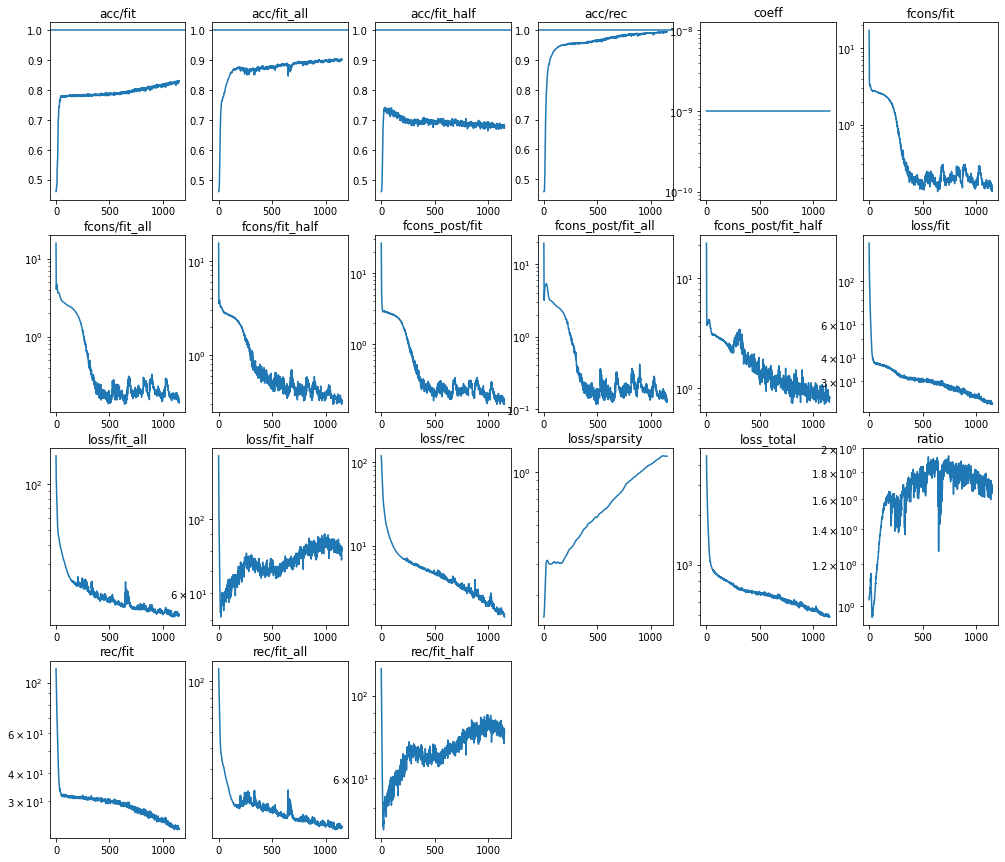

In [941]:
metrics_dict = lstdct2dctlst(metrics_hist)

keys = sorted(metrics_dict.keys())

px = 4
py = 6

assert px * py >= len(keys)

plt.figure(figsize=(17, 15))
for i, key in enumerate(keys, 1):
    plt.subplot(px, py, i)
    plt.title(key)
    data = metrics_dict[key]
    if key.startswith('acc'):
        if np.max(data) >= 0.999:
            data = np.maximum(np.array(data), 0.999)
        plt.axhline(1)
    else:
        plt.yscale('log')
    plt.plot(data)
plt.show()

<AxesSubplot:>

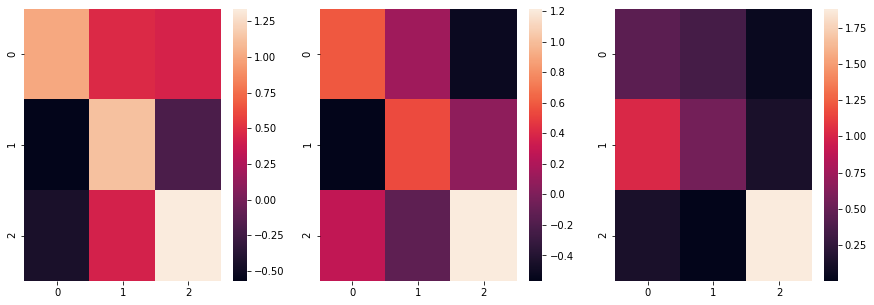

In [942]:
plt.figure(figsize=(15, 5))
# S = nn.Softmax(1)(model_.fc1.weight)
# S = dec.fc1.weight
S = rot1.fc1.weight
Sinv = rot2.fc1.weight
# Sinv = torch.pinverse(S)
plt.subplot(1, 3, 1)
sns.heatmap(S.detach().cpu().numpy())
plt.subplot(1, 3, 2)
sns.heatmap(Sinv.detach().cpu().numpy())
plt.subplot(1, 3, 3)
sns.heatmap((S @ Sinv).abs().detach().cpu().numpy())

Parameter containing:
tensor([[0.0107, 1.0000, 0.0100],
        [0.0960, 0.0100, 0.0100],
        [0.0134, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100],
        [0.0109, 0.0100, 0.0100]], requires_grad=True)


<AxesSubplot:>

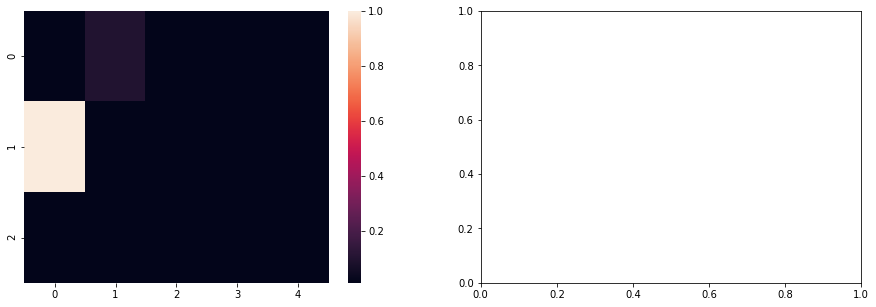

In [943]:
MP = model_.model.switch.probas
plt.figure(figsize=(15, 5))
print(MP)
plt.subplot(1, 2, 1)
sns.heatmap(MP.t().detach().cpu().numpy(), vmin=min_proba, vmax=1)
plt.subplot(1, 2, 2)
# sns.heatmap((Sinv @ MP @ S).detach().cpu().numpy())

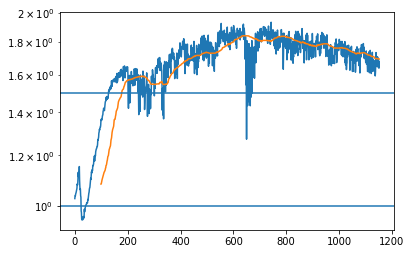

In [944]:
plt.plot(metrics_dict['ratio'])
plt.yscale('log')
plt.plot(pd.Series(metrics_dict['ratio']).rolling(100).median())
plt.axhline(crit_ratio)
plt.axhline(1)

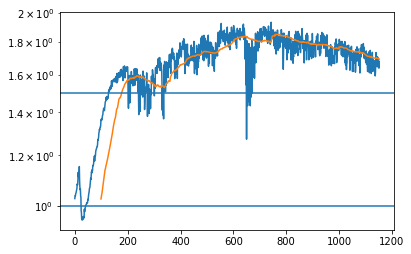

In [945]:
plt.plot(metrics_dict['ratio'])
plt.yscale('log')
plt.plot(pd.Series(metrics_dict['loss/fit']).rolling(100).median() /
         pd.Series(metrics_dict['loss/fit_all']).rolling(100).median())
plt.axhline(crit_ratio)
plt.axhline(1)

In [615]:
#acc -- too bad

In [616]:
crit_ratio

1.5

In [928]:
torch.set_num_threads(7)

In [1245]:
list(nn.BatchNorm1d(10).named_parameters())

[('weight',
  Parameter containing:
  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))]

In [638]:
from sparse_causal_model_learner_rl.loss.losses import fit_loss_obs_space

In [658]:
loss = fit_loss_obs_space(model=model_,
                   rot_pre=rot1,
                   rot_post=rot2,
                   obs_x=obs.flatten(start_dim=1),
                   obs_y=obs_next.flatten(start_dim=1),
                   action_x=torch.zeros(0),
                   decoder=dec,
                   reconstructor=rec,
                   model_forward_kwargs={'enable_switch': True},
                   additional_feature_keys=[],
                   loss_local_cache={})['loss']

In [666]:
?make_dot

Signature: make_dot(var, params=None)
Docstring:
Produces Graphviz representation of PyTorch autograd graph.

Blue nodes are the Variables that require grad, orange are Tensors
saved for backward in torch.autograd.Function

Args:
    var: output Variable
    params: dict of (name, Variable) to add names to node that
        require grad (TODO: make optional)
File:      ~/miniconda3/envs/causal/lib/python3.7/site-packages/torchviz/dot.py
Type:      function


In [668]:
from torchviz import make_dot

# make_dot(loss, params=dict(list(model_.named_parameters()) + list(dec.named_parameters()) +
#                            list(rec.named_parameters()) + list(rot1.named_parameters()) +
#                            list(rot2.named_parameters()))).render("rnn_torchviz", format="png")
make_dot(loss).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [660]:
!pip install torchviz

     |████████████████████████████████| 41 kB 223 kB/s eta 0:00:011
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3521 sha256=672ddd6c57b1202df26df8a9dbf02dea5630a6130b342831c7ebd43487fc1b76
  Stored in directory: /home/sergei/.cache/pip/wheels/10/7b/c8/3af79ec02e294a832c01037bcb38302bbcee0bb020dcbbbd3e
Successfully built torchviz


In [652]:
torch.zeros(0)

tensor([])